**عنوان و هدف پروژه**

<p dir=rtl>
هدف از انجام این پروژه مقدمه ای بر unsupervised learning و کار با داد های بدون لیبل می باشد. بطور دقیق تر استفاده از دو الگوریتم clustering برای خوشه بندی داده ها با استفاده از مدل pre_trained VGG16
</p>

**توضیح کلی پروژه و تعریف صورت مسئله**


<p dir=rtl>
در این پروژه مجموعه داده ای با فرمت تصویر در اختیار ماست که باید در ابتدا با استفاده از مدل VGG16 ویژگی های(features) تصاویر را استخراج کنیم و سپس با استفاده از الگوریتم های خوشه بندی K-means و DBSCAN به خوشه بندی داده ها بپردازیم در نهایت با استفاده از داده لیبل های واقعی تصاویر که در یک فایل CSV در اختبار ما گذاشته شده است، performance خوشه بندی های انجام شده را بررسی کنیم.
</p>

**دیتا های لود شده**


<p dir=rtl>
مجموعه داد های تصویری شامل 210 تصویر + فایل CSV که دارای لیبل های واقعی تصاویر است.
</p>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import os

loading pre-trained VGG16 model

In [ ]:
VGG16_model = VGG16(weights='imagenet')

In [ ]:
VGG16_model.summary()

loading pre-trained VGG16 model
<p dir=rtl>
در این قسمت مدل VGG16 ای که قسمت های fully_connected آن حذف شده را آپلود میکنیم.
</p>

In [5]:
VGG16 = VGG16(weights='imagenet', include_top=False)
VGG16_without_FC = Model(inputs=VGG16.input, outputs=VGG16.output)
VGG16_without_FC.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [6]:
from google.colab import drive
drive.mount('/content/drive')
samples_add = '/content/drive/My Drive/flower_images/'

Mounted at /content/drive


**preprocessing**
resizing images and converting images to BGR format

<p dir=rtl>
در این قسمت بعنوان پیش پردازش، ابعاد همه تصاویر را یکسان میکنیم و همه آنها را به فرمت(BGR) تبدیل میکنیم.در طی این فرانید ربای هر تصویر یک ساختمان داده ای در نظر می گیریم که نام تصویر و همچنین مدل پیش پردازش یافته آن را در ساختمان داده مربوط به آن قرار می دهیم.همچنین فایلcsv که در مجموعه داد ها قرار دارد نیز با استفاده از کتابخانه numpy میخوانیم.
</p>

In [7]:
import cv2
import os
import pandas as pd

def preprocess_image(image_path, target_size=(224, 224)):
  image = cv2.imread(image_path)
  resized_image = cv2.resize(image, target_size)
  if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
    resized_image = resized_image[:, :, ::-1]

  return resized_image

all_preprocessed_images_by_label = []

for file_name in os.listdir(samples_add):
    if file_name.endswith('.png'):
      pp_image = preprocess_image(os.path.join(samples_add, file_name))
      number = file_name
      temp_dict = {'number' : number, 'pp_image' : pp_image}
      all_preprocessed_images_by_label.append(temp_dict)

    elif file_name.endswith('.csv'):
      df_labels = pd.read_csv(os.path.join(samples_add, file_name))

در این قسمت با توجه به نام هر تصویر که در قسمت قبل به ساختمان داده آن اضافه شد، در فایل csv جستجو می کنیم و لیبل واقعی آن تصویر را می یابیم و آن را نیز به ساختمان داده هر تصویر اضافه می کنیم.

In [8]:
#match real labels to each element
labels = {row['file']: row['label'] for _, row in df_labels.iterrows()}

for item in all_preprocessed_images_by_label:
  name = item['number']
  if name in labels:
    item['real_label'] = labels[name]

**extracting features**

<p dir=rtl>
در این قسمت روی ساختما داده مربوط به عکس ها حلقه می زنیم و با استفاده از attribute های مدل VGG16، features تصاویر را استخراج میکنیم و به ساختمان داده آنها اضافه می کنیم.(همانطور که در بخش قبل دیدم تصاویر دیگر خام نیستند و یک سری پیش پردازش روی آنها صورت گرفته است.)
</p>

In [ ]:
for item in all_preprocessed_images_by_label:
  temp_image = image.img_to_array(item['pp_image'])
  temp_image = np.expand_dims(temp_image, axis=0)
  temp_image = preprocess_input(temp_image)
  temp_feature = VGG16_without_FC.predict(temp_image)
  item['features'] = temp_feature

<p dir=rtl>
در این بخش تابعی وجود دارد که بردار همه features همه تصاویر را می گیرد و همچنین یک string بعنوان نام نمودار و سپس آنها را کاهش بعد می دهد و بطور پیش فرض به دو بعد کاهش می دهد که بتوان در صفحه x-y نمایش دادو سپس نقاط را نمایش می دهد.
</p>

In [10]:
from sklearn.decomposition import PCA
#here is a function for show images in a 2D space
def dimention_reduction(features_array, clustring_method_name):
  pca = PCA(n_components=2)
  reduced_dim_features = pca.fit_transform(features_array)

  plt.scatter(reduced_dim_features[:, 0], reduced_dim_features[:, 1], cmap='viridis', alpha=0.5)
  title = clustring_method_name + 'Clustering'
  plt.title(clustring_method_name + 'Clustering')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.colorbar()
  plt.show()

**K-means clustring from scratch**

In [11]:
import random as rd
import math
from sklearn.decomposition import PCA

NUM_OF_CLUSTERS = 15

<p dir=rtl>
در این بخش تابعی وجود دارد که الگوریتم K-means را روی نقاط اجرا میکند. K یعنی تعداد خوشه های مدننظر را بعنوان ورودی می گیرد . به همان تعداد از بین تصاویر موجود تصویر رندوم در ابتدا انتخاب می کند سپس تا موقعی که الگوریتم همگرا شود فاصله بقیه نقاط را از این نقاط می سنجد و خوشه هر نقطه را مشخص می کند و در آخر نقاط مرکزی جدید را با میانگین گیری از نقاط درون خوشه مشخص می کند و این کار را تا همگرایی الگوریتم انجام می دهد.همچنین هر بار همه نقاطی که در یک کلاستر قرار دارند را جمع آوری می کند و در نهایت بعنوان خروجی بر می گرداند.
</p>

In [12]:
#K-mean method from scratch
def K_mean_method(num_of_clusters):
  cluster_points = rd.sample(all_preprocessed_images_by_label, num_of_clusters)
  for i in range(len(cluster_points)):
    cluster_points[i] = cluster_points[i]['features']
  new_cluster_points = cluster_points
  finish = 0
  i = 0
  while(finish != 1):
    for item in all_preprocessed_images_by_label:
      distances = []
      for point in cluster_points:
        differences = point - item['features']
        distance = math.sqrt(np.sum(differences ** 2))
        distances.append(distance)
      distances = np.array(distances)
      min_index = np.argmin(distances)
      item['label'] = min_index

    grouped_images = {key: [] for key in range(num_of_clusters)}
    for item in all_preprocessed_images_by_label:
      grouped_images[item['label']].append(item['features'])

    new_cluster_points = []
    for label, features_list in grouped_images.items():
      mean_of_features = np.mean(features_list, axis=0)
      new_cluster_points.append(mean_of_features)

    if(all(np.array_equal(a, b) for a, b in zip(cluster_points, new_cluster_points))):
      finish = 1
    i += 1
    cluster_points = new_cluster_points
  return grouped_images

<p dir=rtl>
در این قسمت تابعی وجود دارد که روی ساختمان داده های مربوط به همه تصاویر حلقه می زند و لیبل های واقعی و لیبل های پیش بینی شده توسط K-means را جدا می کند و سپس امتیاز homogeneity را محاسبه کرده و آن را خروجی می دهد.
</p>

In [13]:
#check correctness of clustering
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import homogeneity_score

def calculate_homogenity_score_of_clustering(num_of_clusters):
  real_labels = []
  predicted_labels = []
  for item in all_preprocessed_images_by_label:
    real_labels.append(item['real_label'])
    predicted_labels.append(item['label'])

  homogeneity = homogeneity_score(real_labels, predicted_labels)

  return homogeneity

<p dir=rtl>
در این بخش تابعی وجود دارد که یک لیست بعنوان اطلاعات محور افقی و یک لیست بعنوان اطلاعات محور عمودی می گیرد و نمودار دوبعدی مربوطه را رسم می کند.
</p>

In [14]:
#show results
import matplotlib.pyplot as plt

def show_results(horizontal_axis, vertical_axis, type_of_score):
  plt.plot(horizontal_axis, vertical_axis, marker='o', linestyle='-')
  plt.xlabel('Number of Clusters')
  plt.ylabel(type_of_score)
  plt.title(type_of_score + ' vs Number of Clusters')

  plt.grid(True)
  plt.show()

<p dir=rtl>
در این قسمت یک حلقه اجرا می شود که الگوریتم K-means را با تعداد خوشه های برابر با متغیر حلقه اجرا میکند و سپس امتیاز homogeneity را برای آنها اندازه گیری می کند و به یک لیست اضافه میکند.همچنین به ازای هر خوشه بندی که انجام می شود، نقاط درون هر خوشه به dict_grouped_images_according_to_k اضافه می شوند.
</p>

In [15]:
#calculating homogenity and silhouette scores

dict_grouped_images_according_to_k = []
scores_k_mean_scratch = []
num_of_clus = []
for num_of_clusters in range(2, NUM_OF_CLUSTERS + 1):
  grouped_image = K_mean_method(num_of_clusters)
  dict_grouped_images_according_to_k.append(grouped_image)
  num_of_clus.append(num_of_clusters)
  homogeneity = calculate_homogenity_score_of_clustering(num_of_clusters)
  scores_k_mean_scratch.append(homogeneity)

**here I show all points in a 2D space and in the next part I will show points in the same cluster by a special color**

<ipython-input-10-8d1d8da8c3df>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_dim_features[:, 0], reduced_dim_features[:, 1], cmap='viridis', alpha=0.5)


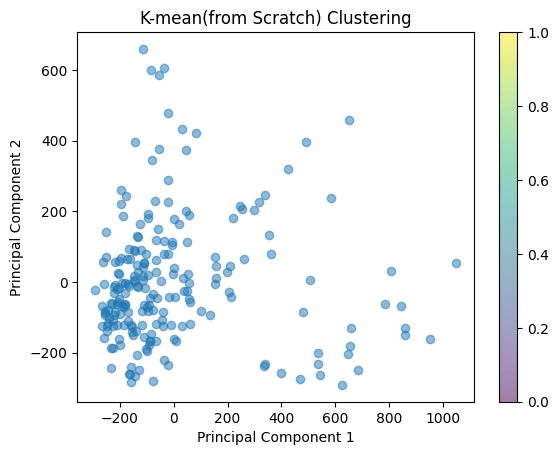

In [16]:
k_means_scratch_features = []
for item in all_preprocessed_images_by_label:
  k_means_scratch_features.append(item['features'].flatten())

dimention_reduction(k_means_scratch_features, 'K-mean(from Scratch) ')

<p dir=rtl>
در این قسمت نقاط خوشه بندی شده با یک K دلخواه در دو بعد و سه بعد نمایش داده شده اند.
</p>

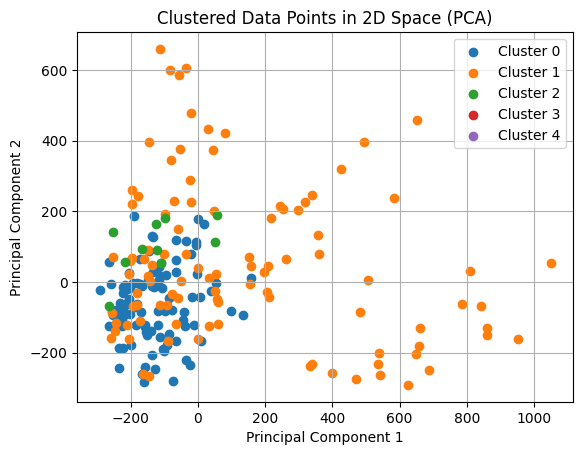

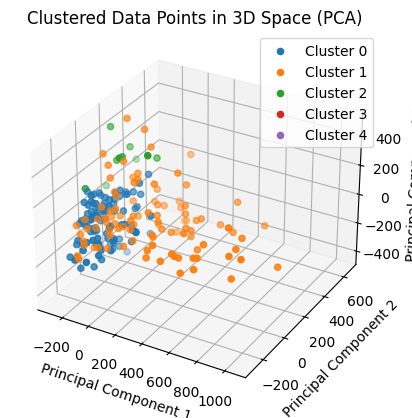

In [17]:
from mpl_toolkits.mplot3d import Axes3D

def show_2D_points_according_to_cluster_by_defferent_color(dictionary_of_label_and_features):
  all_features = sum(dictionary_of_label_and_features.values(), [])
  for i in range(len(all_features)):
    all_features[i] = all_features[i].flatten()
  all_features = np.array(all_features)
  # 2D
  pca = PCA(n_components=2)
  reduced_features = pca.fit_transform(all_features)

  for label, data in dictionary_of_label_and_features.items():
      x = reduced_features[label * 100: (label + 1) * 100, 0]  # Extract x coordinates
      y = reduced_features[label * 100: (label + 1) * 100, 1]  # Extract y coordinates
      plt.scatter(x, y, label=f'Cluster {label}')

  plt.title('Clustered Data Points in 2D Space (PCA)')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.legend()
  plt.grid(True)
  plt.show()

  #3D
  pca = PCA(n_components=3)
  reduced_features = pca.fit_transform(all_features)

  # Plot the reduced features for each cluster in 3D space
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')  # Create 3D subplot

  # Plot data points in 3D space
  for label, data in dictionary_of_label_and_features.items():
      x = reduced_features[label * 100: (label + 1) * 100, 0]  # Extract x coordinates
      y = reduced_features[label * 100: (label + 1) * 100, 1]  # Extract y coordinates
      z = reduced_features[label * 100: (label + 1) * 100, 2]  # Extract z coordinates
      ax.scatter(x, y, z, label=f'Cluster {label}')

  # Set labels for the axes
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_zlabel('Principal Component 3')
  plt.title('Clustered Data Points in 3D Space (PCA)')
  plt.legend()
  plt.show()
show_2D_points_according_to_cluster_by_defferent_color(dict_grouped_images_according_to_k[3])

<p dir=rtl>
در این قسمت امتیاز های homogeneity که در قسمت های قبل به ازای تعداد خوشه ها محاسبه شد نشان داده شده اند.
</p>

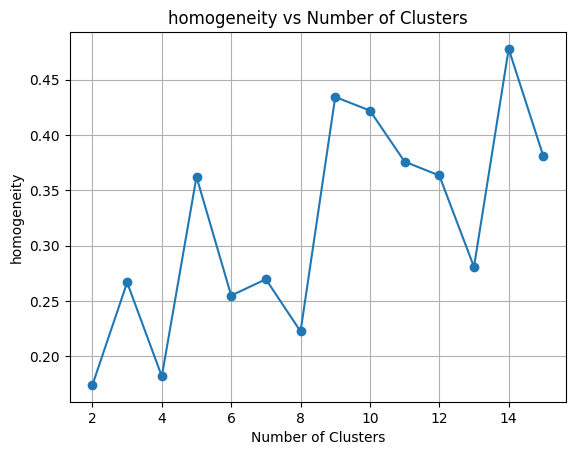

In [18]:
show_results(num_of_clus, scores_k_mean_scratch, 'homogeneity')

**K-means ckustering using library**

<p dir=rtl>
در قسمت بعدی الگوریتم K-means با استفاده از کتابخانه sklearn پیاده سازی شده است.
</p>

In [19]:
from sklearn.metrics import silhouette_score

def silhouette_scores_calculator_k_mean(features_array, cluster_labels):#this function get array of all images features and returns silhouette scores of clustring
  distances = np.zeros((len(features_array), len(features_array)))

  for i in range(len(features_array)):
    for j in range(i+1, len(features_array)):
        distances[i][j] = distances[j][i] = np.linalg.norm(features_array[i] - features_array[j])
  silhouette_scores = silhouette_score(distances, labels, metric='precomputed')
  average_silhouette_score = np.mean(silhouette_scores)

  return average_silhouette_score

In [20]:
import matplotlib.pyplot as plt
import numpy as np

<p rtl=dir>
در آخر این بخش نقاط مرتبط با تصاویر که به دو بعد کاهش یافته اند نمایش داده شده اند بطوری که نقاط با خوشه یکسان رنگ یکسان دارند.
</p>

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, Normalizer

def calculate_homogeneity_of_clustering(num_of_clusters, cluster_labels):
  real_labels = []
  for item in all_preprocessed_images_by_label:
    real_labels.append(item['real_label'])
  homogeneity = homogeneity_score(real_labels, cluster_labels)
  return homogeneity

list_of_features_vectors = []
for item in all_preprocessed_images_by_label:
  list_of_features_vectors.append(item['features'].flatten())
features_array = np.array(list_of_features_vectors)

wcss_for_each_k = []
homogenity_k_mean_library = []
silhouette_k_mean_library = []
for num_of_clusters in range(2, NUM_OF_CLUSTERS + 1):
  scaler = Normalizer()
  norm_features_array = scaler.fit_transform(features_array)
  pca = PCA(n_components=2)
  features_array = pca.fit_transform(features_array)
  kmeans = KMeans(n_clusters=num_of_clusters)
  kmeans.fit(features_array)
  silhouette = silhouette_score(features_array, kmeans.labels_)
  wcss_for_each_k.append(kmeans.inertia_)#this is for finding the best K for K-means algorithm using elbow-finding method
  cluster_labels = list(kmeans.labels_)
  homogeneity = calculate_homogeneity_of_clustering(num_of_clusters, cluster_labels)
  homogenity_k_mean_library.append(homogeneity)
  silhouette_k_mean_library.append(silhouette)
  if(num_of_clusters == 10):
    np.random.seed(0)
    points = features_array
    colors = plt.cm.tab10(cluster_labels)
    print(len(cluster_labels))
    plt.scatter(points[:, 0], points[:, 1], c=colors)
    plt.title('Clustered Points with tab10 Colors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

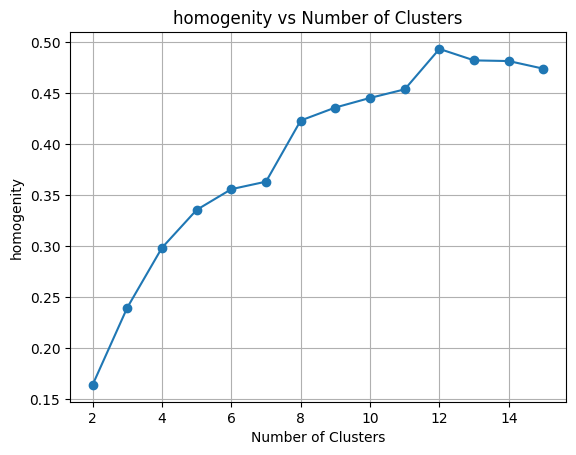

In [22]:
show_results(num_of_clus, homogenity_k_mean_library, 'homogenity')

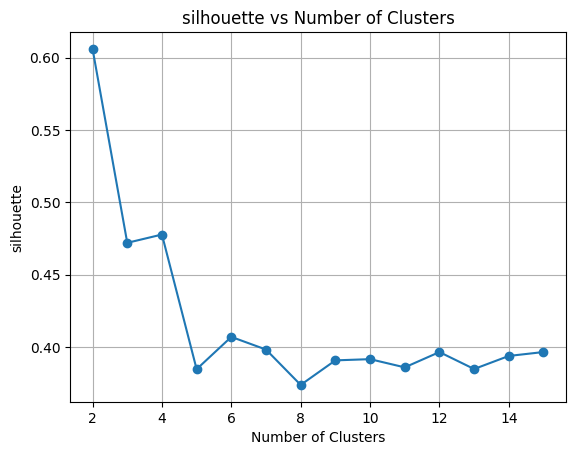

In [23]:
show_results(num_of_clus, silhouette_k_mean_library, 'silhouette')

<p dir=rtl>
در این بخش نمودار مربوط به روش elbow-finding رسم شده است ولی شکستگی محسوسی در نمودار مشاهده نمی شود که مشخص شود چه K بهترین است.
</p>

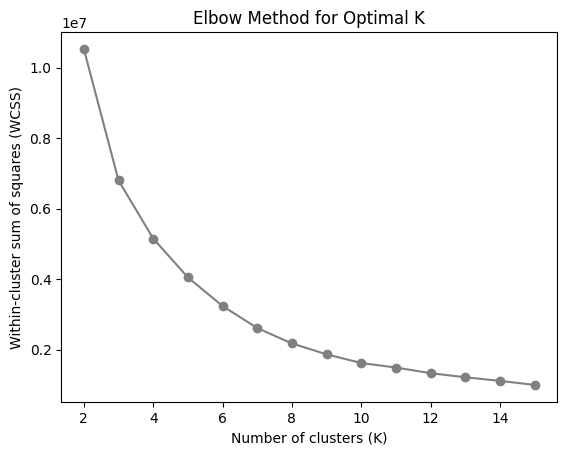

In [24]:
#here is the plot that we find the best number of clusters for our dataset
plt.plot(num_of_clus, wcss_for_each_k, marker='o', color='gray')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.show()

**BDSCAN by library**

<p dir=rtl>
در این قسمت از روش DBSCAN برای clustering استفاده شده است که برای اینکه امتیاز های homogenity و silhouette_score به مقادیر قابل قبولی برسند، از کاهش بعد استفاده شده است.همچنین نویز ها با رنگ مشکی مشخص شده اند.
</p>

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer

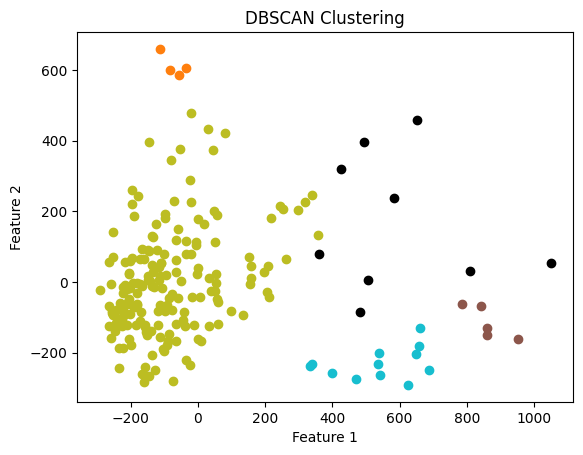

[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  1  0  0  0  2  0  0 -1
  0  0  0  0  0  0  1 -1  0  3  0  0  0  0  0  0  0  0  0  0  2  0  0  0
  0  0  0  0  0  0  0  0  0  2 -1  0  0  0  0  0  0  0  0  4  0  0  0  0
  0  0  0  0  0  0  0  0  0  2  3  0  0  2  5  0  0  0  0  4 -1  0  0  5
  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  4  0  0  0 -1  0
  0  1  0  0  0  0  0  0  4  0  1  1  0  0  0 -1  0  5  3  0  2  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  2
  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  2  2  0  0  0  0  3  0  0  0  0  0  0  5  0  2 -1]
Homogenity:  1.0
Num of Clusters: 6
Number of Noise 9
Silhouette Score: 0.4406991


In [30]:
eps = 95
min_samples = 4

true_labels = []
list_of_features_vectors = []
for item in all_preprocessed_images_by_label:
  true_labels.append('real_label')
  list_of_features_vectors.append(item['features'].flatten())

features_array = np.array(list_of_features_vectors)
# scaler = StandardScaler()
# norm_features_array = scaler.fit_transform(features_array)
pca = PCA(n_components=2)
reduced_dim_features = pca.fit_transform(features_array)

DBscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_of_dbscan = DBscan.fit_predict(reduced_dim_features)
n_clusters = len(set(labels_of_dbscan)) - (1 if -1 in labels_of_dbscan else 0)
n_noise = list(labels_of_dbscan).count(-1)

zcolors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_clusters)]
for label, color in zip(set(labels_of_dbscan), colors):
    if label == -1:
        color = [0, 0, 0, 1]
    cluster_points = reduced_dim_features[labels_of_dbscan == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.show()



homogenity = homogeneity_score(true_labels, labels_of_dbscan)
sil = silhouette_score(reduced_dim_features, labels_of_dbscan)
print(labels_of_dbscan)
print('Homogenity: ', homogenity)
print('Num of Clusters:', n_clusters)
print('Number of Noise', n_noise)
print('Silhouette Score:', sil)

**راهکار هایی برای بهبود عملکرد مدل**

<p dir=rtl>
یکی از راهکار هایی که برای بهبود عملکرد این پروژه می توان به آن اشاره کرد این است که مجموعه داده ها اندازه بزرگ تری داشته باشد. قاعدتا هر چه تعداد داده ها بیشتر باشد و تنوع بیشتری داشته باشد، قدرت مدل برای خوشه بندی بیشتر می شود.
</p>


<p dir=rtl>
در این پروژه از آنجایی که استخراج ویژگی ها بر عهده مدل pre-traind VGG16 است و ما از جزییات این کار خبر نداریم، نمیتوان بطور حتم گفت ولی یکی دیگر از کارهایی که میتوان برای بهبود عملکرد این مدل انجام داد این است که پس زمینه تصاویر را حذف کنیم و صرفا اصل گل را در نظر بگیریم ، در اینصورت اطلاعاتی که برای خوشه بندی باقی می ماند تنها اطلاعات مفید خواهد بود و اطلاعاتی که باعث انحرا مدل از پیش بینی درست می شود دیگر وجود ندارند که اثر منفی خود را بگذارند.
</p>

**questions of preprocessing and extracting features**

1)<p dir=rtl>
استفاده از مقادیر پیکسل های خام،اطلاعات بسیار محدودی را درباره تصویر ارائه می دهند که همان اطلاعات رنگی آنهاست اما اطلاعات معنایی درباره محتوای تصاویر را به طور ذاتی نشان نمی دهند.از طرفی مدل های VGG16 مدل هایی هستند که بر روی مجموعه داده های بسیار بزرگی train شده اند تا بتوانند ویژگی های سلسله مراتبی را از تصاویر استخراج کنند.این مدلها یاد می گیرند چطور الگو ها و و یژگی های انتزاعی در سطوح مختلف را در تصاویر شناسایی کنند.اطلاعاتی مانند لبه ها(edges)، بافت ها، شکل ها و ترکیبات اشیا.درواقع با بهره گیری از این ویژگی ها که از تصاویر استخراج می کنیم میتوان نمایش معنادارتری برای تصاویر ایجاد کرد که به کارهایی مثل خوشه بندی(clustering)، طبقه بندی و  همچننین شناسایی تصاویر کمک می کنند.
</p>

2)

Machines store images in the form of a matrix of numbers. The size of this matrix depends on the number of pixels we have in any given image.

A colored image is typically composed of multiple colors and almost all colors can be generated from three primary colors – red, green and blue.

Hence, in the case of a colored image, there are three Matrices (or channels) – Red, Green, and Blue. Each matrix has values between 0-255 representing the intensity of the color for that pixel.Also, there are various other formats in which the images are stored. RGB is the most popular one

**Top 3 Techniques to Extract Features from Image**

* **Grayscale Pixel Values as Features:**

The simplest way to create features from an image is to use these raw pixel values as separate features.Consider the size of image is (n * m), so the number of features will be the same as the number of pixels(n * m)!We simply append every pixel value one after the other to generate a feature vector.

* **Mean Pixel Value of Channels:**

This time, the image has a dimension (n, m, 3), where 3 is the number of channels. We can go ahead and create the features as we did previously. The number of features, in this case, will be (n * m * 3).
Instead of using the pixel values from the three channels separately, we can generate a new matrix that has the mean value of pixels from all three channels.By doing so, the number of features remains the same and we also take into account the pixel values from all three channels of the image.The new matrix will have the same height and width but only 1 channel. We append the pixel values one after the other to get a 1D array.

* **Extracting Edge Features:**

A similar idea is to extract edges as features and use that as the input for the model. Edge is basically where there is a sharp change in color.So, we will look for pixels around which there is a drastic change in the pixel values.There are various kernels that can be used to highlight the edges in an image like using the Prewitt kernel (in the x-direction).We take the values surrounding the selected pixel and multiply it with the selected kernel (Prewitt kernel). We can then add the resulting values to get a final value.

**queastions of implementing k-means and dbscan**

4)

K-means and DBScan (Density Based Spatial Clustering of Applications with Noise)  are two of the most popular clustering algorithms in unsupervised machine learning.

* **K-Means Clustering**: K-means is a centroid-based or partition-based clustering algorithm.  This algorithm partitions all the points in the sample space into K groups of similarity. The similarity is usually measured using Euclidean Distance .

Algorithm :

    K centroids are randomly placed, one for each cluster.
    Distance of each point from each centroid is calculated
    Each data point is assigned to its closest centroid, forming a cluster.
    The position of K centroids are recalculated.

* **DBScan Clustering**: DBScan is a density-based clustering algorithm. The key fact of this algorithm is that the neighbourhood of each point in a cluster which is within a given radius (R) must have a minimum number of points (M). This algorithm has proved extremely efficient in detecting outliers and handling noise.

Algorithm:

    The type of each point is determined. Each data point in our dataset may be either of the following :
        Core Point: A data point is a core point if, there are at least M points in its neighborhood ie, within the specified radius (R).
        Border Point: A data point is classified as a BORDER point if:
            Its neighborhood contains less than M data points, or
            It is reachable from some core point ie, it is within R-distance from a core point.
        Outlier Point: An outlier is a point that is not a core point, and also, is not close enough to be reachable from a core point.
    The outlier points are eliminated.
    Core points that are neighbors are connected and put in the same cluster.
    The border points are assigned to each cluster.

**Some differences between K-means and dbscan**
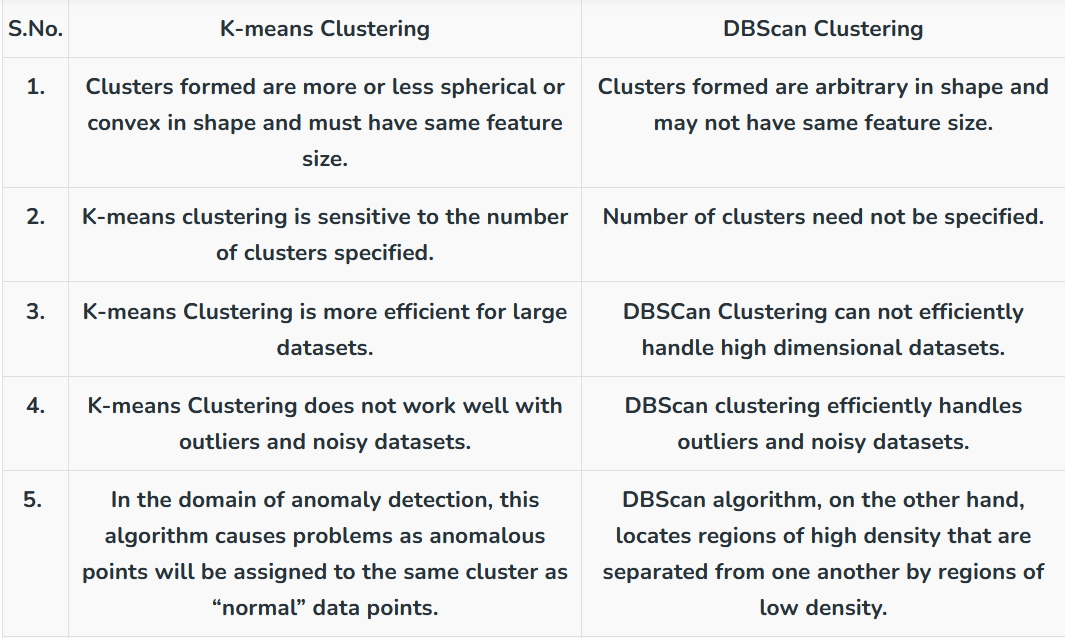

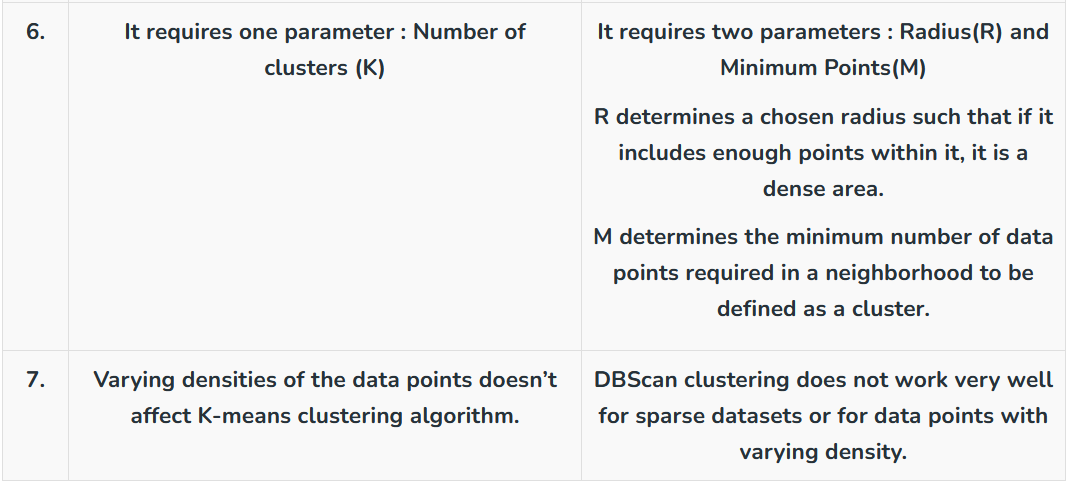


5)

There are several methods to find the best k for K-means clustering I use homogeneity score to find the best K.

**questions of dimention reduction**

7)

Principal Component Analysis (PCA) is a mathematical technique used in data analysis to simplify complex data while retaining important patterns and trends. It's often used in fields like statistics, machine learning, and data science.

PCA helps you find a new way to describe these data points, but in a more compact and informative manner. It does this by finding new axes or directions in the data called "principal components." These components are chosen in such a way that the first one captures the most variance (spread) in the data, the second captures the next most, and so on.

In essence, PCA takes your original data, which might be spread out in many directions, and finds a new coordinate system where the data is more concentrated along a few axes. This can make it easier to analyze and visualize the data because you've reduced the dimensionality (number of features) while preserving the most important information.

In summary, PCA is a technique for simplifying complex data by finding new axes (principal components) that capture the most important information, making it easier to analyze and understand the data.

**questions of analysis**

8)

**Homogeneity score:**The homogeneity score is a metric to measure the homogeneity of a clustering. A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

This clustering metric is an extrinsic measure, because it requires ground truth clustering labels, which may not be available in practice since clustering in generally is used for unsupervised learning.

Homogeneity measures how much the sample in a cluster are similar. It is defined using the Shannon’s entropy.
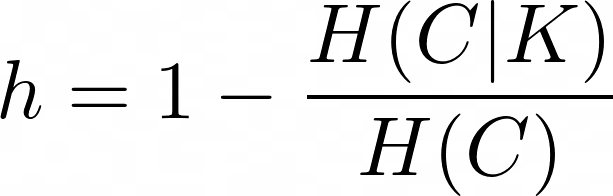

Given H(C|K) formula.

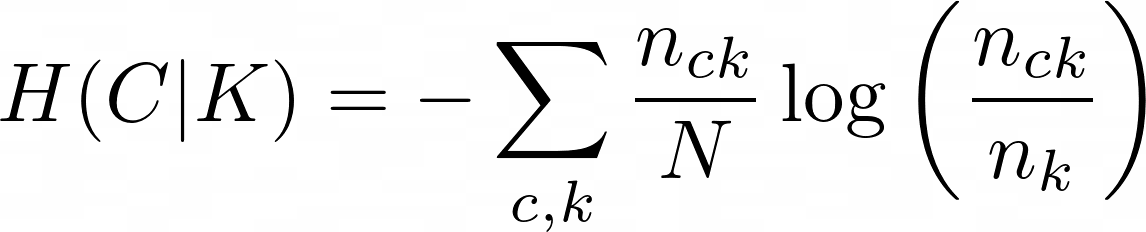

It is easy to understand why this is the case. If one looks at the term H(C|K) it contains n𝒸ₖ / nₖ which represents the ratio between the number of samples labelled c in cluster k and the total number of samples in cluster k.

When all samples in cluster k have the same label c, the homogeneity equals 1.
However, it's important to note that the homogeneity score alone may not provide a complete picture of clustering quality, and it's often used in combination with other clustering evaluation metrics such as completeness, silhouette score, or adjusted Rand index for a more comprehensive assessment.


**Silhouette Coefficient(Silhouette Score):**

It is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

1: Means clusters are well apart from each other and clearly distinguished.so we can say that the clusters are well apart from each other as the silhouette score is closer to 1.

0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

-1: Means clusters are assigned in the wrong way.

**Silhouette Score = (b-a)/max(a,b)** such that:


a= average intra-cluster distance i.e the average distance between each point within a cluster.

b= average inter-cluster distance i.e the average distance between all clusters.

When dealing with higher dimensions, the silhouette score is quite useful to validate the working of clustering algorithm as we can’t use any type of visualization to validate clustering when dimensions are greater than 3.

We can also use the silhouette score to check the optimal number of clusters.

**sources**

*  https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/

*  https://www.geeksforgeeks.org/difference-between-k-means-and-dbscan-clustering/

*  https://www.linkedin.com/pulse/principal-component-analysis-pca-simple-terms-daniel-gaio

*  https://lightning.ai/docs/torchmetrics/stable/clustering/homogeneity_score.html